In [1]:
%%capture
import numpy as np
import pandas as pd
import generate_synthetic_data as generate
import classify_synthetic_data as classify
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction: Gender bias in hiring

Our dataset represents applicants for a job. We want an algorithm to help making hiring decisions, as this process is rife with human bias. However,
studying past data would simply reinforce these biases (as we will see below).

Consider gender in hiring decisions. There is a well-documented [gender pay gap](https://en.wikipedia.org/wiki/Gender_pay_gap): in general, people who identify as women are paid less for the same work than people who identify as men. 

Now, imagine that we want to build a classifier that will make hiring decisions. If we train a classifier to make hiring decisions based on prior work experience and income, we would expect the classifier to *learn* a bias against women. Put another way, we can't make a classifier that is "gender-blind" by simply "throwing out" gender, excluding it from our dataset. Information about gender is already correlated with income.

We do not want our algorithm to learn this bias for gender. **Instead,
we would like our algorithm to *correct* for this bias.**

To discuss this issue more deeply, let's introduce some key terms:

- **Sensitive** features: A feature is *sensitive* when it may contribute to bias. For example, gender is a *sensitive* feature.
- **Protected** classes: A class is *protected* when we expect there is bias against it. For example, being female is a *protected* class in this example.

Let's generate a synthetic dataset that contains the prior income, work experience, and gender of 1,000 applicants who were hired and 1,000 applicants who were not. (For a more detailed explanation of how we generate this toy dataset, see the Appendix below.) 

We represent each individual on the plot below according to their prior income and work experience (the non-sensitive features). The shape of the marker indicates the applicant's gender (the *sensitive* feature). Females, denoted by `x`s, are the *protected* class in this example. The color indicates whether or not they were hired.

<!-- The binary sensitive feature includes a protected group (sensitive feature = 0) and an unprotected group (sensitive feature = 1). **(EXPLAIN WHAT PROTECTED/UNPROTECTED MEANS)** -->


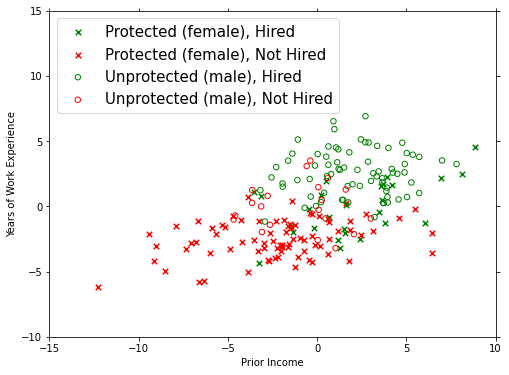

In [2]:
X, y, x_sensitive = generate.generate_synthetic_data(plot_data=True)

The variables here are `X` (non-sensitive feature: years of prior work experience), `y` (label: hired/not-hired), and `x_sensitive` (male/female).

Here, we have effectively created a biased dataset where the sensitive feature *gender* is strongly related to the applicant's hiring status. A female applicant (`x`) seems less likely than a male applicant (`o`) to be hired.
(Again, this is just example data---while gender gap in pay is real, this particular data is synthetic. See the appendix for details.)

## Part 1: Defining Fairness

In order to remove bias from our model, we first need to define bias. 

In this assignment, we will be using **disparate impact** (also known as the **p%-rule**) to measure the unfairness of a data set with respect to a particular sensitive feature. We can measure *how biased* our dataset is by calculating the p%-rule.

### 1.1 Calculate the p% rule

If we take $\mathbf x$ to represent a (non-sensitive) feature vector, $y$ a 1/-1 class label, and $z$ a 0/1 sensitive attribute, the p%-rule states that the ratio between the fraction of subjects assigned the positive decision outcome ($y=1$) given that they have a sensitive attribute value and the fraction of subjects assigned the positive outcome given that they do not have that value should be no less than p%.

In the scenario we described in this lab, the non-sensitive feature vector $\mathbf x$ represents prior income and years of work experience, the class label $y$ represents the hiring status (1 for hired, -1 for not hired), and the sensitive attribute $z$ represents gender (0 for female, 1 for male). The p%-rule would tell us the ratio between the fraction of female applicants who were hired and the fraction of male applicants who were hired.


$$ p = 100\left(\frac{Pr(y=1|z=1)}{Pr(y=1|z=0)}\right) $$




In [3]:
sensitive_features_arr  = np.array(x_sensitive['s1'])

In [4]:
# TODO: Write a function compute_p_rule that takes as inputs a sensitive_features_arr and y (the array of 
# hiring outcomes), and returns the p percent rule. Also have your function print out the number of observations
# in the protected and unprotected class, and the percent of observations in each class that are hired (y=1).

def calculate_p_rule(sensitive_features_arr, y):
    # TODO: Replace 0 in the next line with a calculation of the # of unprotected observations
    number_unprotected = sum(sensitive_features_arr == 1.0) 
    
    # TODO: Replace 0 in the next line with a calculation of the # of protected observations
    number_protected = sum(sensitive_features_arr == 0.0)
    
    # TODO: Replace 0 in the next line with a calculation of the % of unprotected observations hired
    percent_pos_unprotected = float(sum(y[sensitive_features_arr == 1.0] == 1.0)) / float(number_unprotected)
    
    # TODO: Replace 0 in the next line  with a calculation of the % of protected observations hired
    percent_pos_protected = float(sum(y[sensitive_features_arr == 0.0] == 1.0)) / float(number_protected) 
    
    # TODO: Replace 0 with a calucalation of the p percent rule, using the previously-defined variables
    p_percent_rule = (percent_pos_protected/percent_pos_unprotected) * 100.0
    
    print('Number of protected observations: %i' % number_protected)
    print('Number of unprotected observations: %i' % number_unprotected)
    print('Protected in positive class: %i' % round(percent_pos_protected * 100.0) + '%')
    print('Unprotected in positive class: %i' % round(percent_pos_unprotected * 100.0) + '%')
    print('P-rule: %i' % round(p_percent_rule) + '%')
    
    return p_percent_rule

Now test your function using the sensitive_features_arr and hiring outcomes (*y*) from our dataset. Verify that your function is correct: it should output p-percent rule of 29.45%. If you get a different number, go back and correct your code!

In [5]:
calculate_p_rule(sensitive_features_arr, y)

Number of protected observations: 1075
Number of unprotected observations: 925
Protected in positive class: 24%
Unprotected in positive class: 81%
P-rule: 29%


29.45216169814266

## Discussion

**QUESTION A:** Interpret the output of this method to describe the disparate impact between male and female applicants in the training data.

*Answer:* 
In our dataset of synthetic data for 2000 job applicants, 1075 are female and 925 male. Out of those 1075, only 24% (255) of female applicants are hired, while 81% (745) of male applicants are hired. The disparate impact (p%-rule) is the ratio between these values (0.24/0.81), which tells us that the rate at which women are hired is only 29.45% of the rate at which men are hired.

**QUESTION B:** Is there evidence of bias in the training data?

*Answer:* 
TL;DR: Yes!
Biases can be of many different types, but as defined in this assignment, in our case bias occurs when we have disparate impact. For this reason, we need to come up with a mechanism to make classification outcomes free of disparate impact, that is, to ensure that similar fractions of people from different demographic groups (e.g., males, females) are accepted for the job (or classified as positive) by the classifier. 
However, as we can see from the above observations, the rate at which women are hired is only 29.45% of the rate at which men are hired, or simply put, man are 3 times more likely to get hired, which has disparate impact and as a result our dataset is biased

# Part 2: Machine learning without correcting for bias

Now let's turn back to our dataset. Let's see what happens when we *don't* correct for bias and train a machine learning model on our data.

First, we pre-process the data. We add an intercept column and split the data into train and test sets.

In [6]:
intercept = np.ones(X.shape[0]).reshape(X.shape[0], 1)
X = np.concatenate((intercept, X), axis = 1)
pd.DataFrame(X, columns=["intercept", "income", "experience"]).head() # to help us visualize the dataset

,intercept,income,experience
0,1.0,-1.738503,-1.977414
1,1.0,-4.908148,-3.267064
2,1.0,3.006536,-0.925507
3,1.0,0.779730,2.473575
4,1.0,1.193537,-2.595904


In [7]:
# split the data into training and test using a 70/30 split
train_fold_size = 0.7
X_train, y_train, x_sensitive_train, X_test, y_test,  x_sensitive_test =\
    classify.split_into_train_test(X, y, x_sensitive, train_fold_size)

To set our baseline, we'll train a standard logistic regression classifier on our data and see how it performs. (See appendix for more on how this classifier training works).

In [8]:
theta, p_rule, score, distances_from_decision_boundary = classify.train_test_classifier(
    X_train, y_train,  x_sensitive_train, 
    X_test, y_test, x_sensitive_test, 
    ['s1'],  # our list of sensitive features.
    apply_fairness_constraints=0 # We are NOT applying any fairness constraints this time
)  


Accuracy: 0.87
Protected/non-protected in positive class: 86% / 22%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 1.181



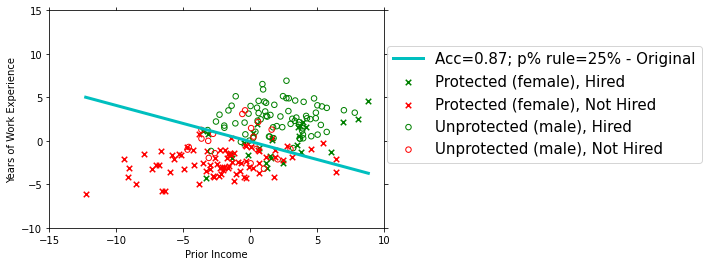

In [9]:
classify.plot_boundaries(X, y, np.array(x_sensitive['s1']), theta, p_rule[0], score)

The blue line represents the decision boundary for our standard logistic regression classifier. The model predicts points above this line as "hired" and points below as "not hired." 

**QUESTION A:** Is our classifier accurate at predicting class labels (as determined by its accuracy rate)?

*Answer:* 
Without any bias correction the model does a fairly good job of accurately predicting the true class labels, since this logistic regression has an 87% accuracy performance. 

**QUESTION B:** Is our classifier fair (as determined by its p% rule)? Explain. Hint: female applicants would be labeled "hired" by this classifier at what rate relative to male applicants?

*Answer:* 
The model's predictions don't have a high p % rule (unfair) because the non-sensitive and sensitive features are significantly coorelated. This classifier predicts that female candidates will be "hired" at a quarter of the rate that it predicts male applicants will be "hired". When we compare the p % rule that we obtained from our initial model's predictions (29%) to the p % rule in the logistic regression (25%), we notice that the model not only learns but also exacerbates the bias contained in the data in its predictions.

**QUESTION C:** How did the classifier learn bias for gender, even though gender was not included?

*Answer:* 
Gender as a sensitive feature was already highly-correlated with the non-sensitive features to the point that the classifier was able to learn the bias from the non-sensitive features alone. The reason why the classifier shows similar biases as ones contained in the data is that the classifier model tries to minimize the loss (or maximize the accuracy) on the training data by learning the patterns in the data as best as possible. One of the patterns was the unfairness in relation to the sensitive feature, and the classifier ended up learning that as well.

# Part 3: Post-processing with alternative thresholds

One option for correcting for this bias is postprocessing model outputs with a method called *thresholding*. This method makes no changes to the classifier itself, but instead processes classifier outputs differently for observations in the protected class and observations in the unprotected class. In the context of this problem set, we can think of thresholds as alternative restrictions on distance from the decision boundary: observations without the sensitive characteristic (males) must be above the decision boundary in order to be hired, but observations with the sensitive characteristic (females) can be up to a distance of *k* below the decision boundary. 

### 3.1 Applying one alternative threshold

First, use the distances_from_decision_boundary obtained earlier from the train_test_classifier function to test out a threshold of 0 for males and a threshold of -1 for females. Identify which observations in the test set will be hired according to these thresholds, and use the compute_p_rule function you wrote earlier to calculate the p% rule. 

In [10]:
sensitive_feature_arr = np.array(x_sensitive_test['s1'])

In [11]:
#br = distances_from_decision_boundary.copy()

In [12]:
# TODO: Post-process the outputed distances_from_decision_boundary to apply a threshold of 0 or over for 
# protected observations (sensitive_feature = 1) and a threshold of -1 or over for unprotected observations
# (sensitive_feature = 0). Calculate the p% rule using these post-processed outputs.

# METHOD 1: IF-ELSE STATEMENTS (NOT VERY EFFICIENT)
# for x in distances_from_decision_boundary[sensitive_feature_arr==0]:
#     if x >= -1:
#         y_test[distances_from_decision_boundary==x] = 1
#     else:
#         y_test[distances_from_decision_boundary==x] = -1
#
# for x in distances_from_decision_boundary[sensitive_feature_arr==1]:
#     if x >= 0:
#         y_test[distances_from_decision_boundary==x] = 1
#     else:
#         y_test[distances_from_decision_boundary==x] = -1

# METHOD 2: LIST COMPREHENSIONS (VERY EFFICIENT AND ONLY 2 LINES OF CODE)
# y_test[sensitive_feature_arr==0] = [1 if x >= -1 else -1 for x in distances_from_decision_boundary[sensitive_feature_arr==0]]
# y_test[sensitive_feature_arr==1] = [1 if x >= 0 else -1 for x in distances_from_decision_boundary[sensitive_feature_arr==1]]

# METHOD 3: FUNCTION (EFFICIENT AND REUSABLE)
df_post = pd.DataFrame(data = sensitive_feature_arr, columns = ['sensitive'])
df_post['dist'] = distances_from_decision_boundary

def hiring_decision(df_post, threshold): 
    
    filters = [
        (df_post.sensitive == 0) & (df_post.dist > threshold),
        (df_post.sensitive == 1) & (df_post.dist > 0), 
        ]

    values = [1, 1]
    df_post["hired"] = np.select(filters, values, default=-1)
    
    sensitive_arr = np.array(df_post['sensitive'])
    y = np.array(df_post['hired'])
    
    # Calculating the p-rule with the revised hiring predictions given the threshold.
    print("--------------------")
    print("Results for Revised Hiring Decisions considering a threshold of {} for the protected group".format(threshold),'\n')
    p_rule_val = calculate_p_rule(sensitive_arr, y)

    
    return p_rule_val, df_post
    

p_rule_val, final_df = hiring_decision(df_post, -1)

--------------------
Results for Revised Hiring Decisions considering a threshold of -1 for the protected group 

Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 30%
Unprotected in positive class: 86%
P-rule: 35%


In [13]:
#calculate_p_rule(sensitive_feature_arr, y_test)

## Discussion

**QUESTION A:** Is this decision method more or less fair than the naive decision method with equal thresholding implemented earlier? Why?

*Answer:* 
The "alternative thresold" method (of -1 for females and 0 for males) is more equitable than the previous naïve decision method with equal thresholding of zero. This is supported by the fact that we obtained a higher p-rule value with this model (35%) versus 29.45% with the no threshold variant. More specifically:
1.  Naive Decision Model
- Protected in positive class: 24%
- Unprotected in positive class: 81%

2.  Alternative Theshold Model
- Protected in positive class: 30%
- Unprotected in positive class: 86%

Both groups (male/female) saw increases in hiring, where females had a 6% jump and males a 5% jump and that is attributed to the fact that the lower threshold in females (-1), classified more females as hired. An increase in males is seen because the treshold of 0 was enforced in all the testing set + it depends from the type of the split in the data (test/train) and the % of each group in the splits.

### 3.2 Varying the threshold

Now let's try out a set of different thresholds. Assume that we will leave the threshold for the unprotected class (males) at 0. Try out a set of thresholds for the protected class (females) between -8 and 0. Try out at least 20 thresholds in this range, and plot the results in a scatterplot, with the threshold on the x-axis and the p% rule on the y-axis. Calculate the threshold at which the p% rule is closest to 100%, and add a vertical line to the scatterplot showing this threshold. Remember to make sure your plot is readable and well-labeled

In [46]:
# TODO: Post-process the outputed distances_from_decision_boundary to apply a threshold of 0 for protected 
# observations and a threshold of k for unprotected observations (sensitive_feature = 0), and calculate the 
# p% rule. Experiment with at least 20 different values of k between -8 and 0.

thresh_list = np.linspace(0, -8, 30)
p_rule_vals = []

for thresh in thresh_list:
    p_rule_val, final_df = hiring_decision(df_post, thresh)
    p_rule_vals.append(p_rule_val)
    
# METHOD 2: USING LIST COMPREHENSIONS
# threshold_list = np.linspace(-8,0,30)
# p_rules = []

# for i in threshold_list:
#     print('\n******** For treshold = {} ******'.format(i))
#     y_test[sensitive_feature_arr==0] = [1 if x >= i else -1 for x in distances_from_decision_boundary[sensitive_feature_arr==0]]
#     #calculate_p_rule(sensitive_feature_arr, y_test)
#     p_rules.append(calculate_p_rule(sensitive_feature_arr, y_test))

--------------------
Results for Revised Hiring Decisions considering a threshold of 0.0 for the protected group 

Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 22%
Unprotected in positive class: 86%
P-rule: 25%
--------------------
Results for Revised Hiring Decisions considering a threshold of -0.27586206896551724 for the protected group 

Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 24%
Unprotected in positive class: 86%
P-rule: 28%
--------------------
Results for Revised Hiring Decisions considering a threshold of -0.5517241379310345 for the protected group 

Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 26%
Unprotected in positive class: 86%
P-rule: 30%
--------------------
Results for Revised Hiring Decisions considering a threshold of -0.8275862068965517 for the protected group 

Number of protect

In [16]:
# print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# print(f"The best treshold is: {min(p_rules, key=lambda x:abs(x-100))}") 

In [17]:
#distances_from_decision_boundary==br

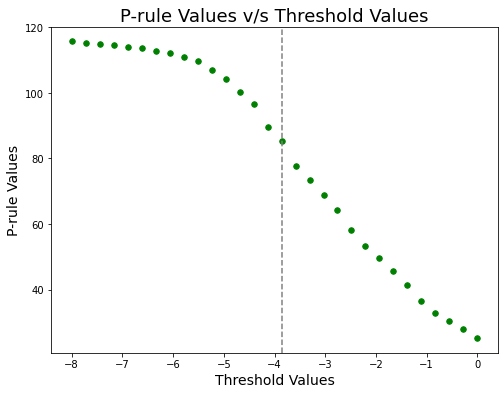

In [48]:
# Plotting threshold values on the x-axis and p-rule values on the y-axis. 

fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(thresh_list, p_rule_vals, color='green', marker='o', s=30)
plt.axvline(thresh_list[14], color='grey', linestyle = '--')
ax.set_title("P-rule Values v/s Threshold Values", fontsize=18)
ax.set_xlabel("Threshold Values", fontsize=14)
ax.set_ylabel("P-rule Values", fontsize=14)
plt.show()

# Part 4: In-processing with fairness constraints

An alternative method for correcting for bias is applying fairness constraints in training the machine learning algorithm.

You can see the appendix for more information on how this process works (see Appendix: Applying fairness constraints. But it's best illustrated with an example.

Below, you're going to pick a **hyperparameter gamma**
($\gamma$).
I've set a value of 1.5. See what happens.


Accuracy: 0.41
Protected/non-protected in positive class: 60% / 56%
P-rule achieved: 93%
Covariance between sensitive feature and decision from distance boundary : 0.002



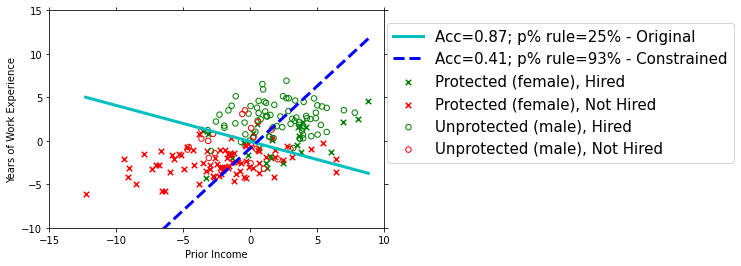

In [19]:
theta1, p_rule1, score1, distances_from_decision_boundary = classify.train_test_classifier(
    X_train, y_train, x_sensitive_train, 
    X_test, y_test, x_sensitive_test, 
    ['s1'],  # our sensitive feature
    apply_accuracy_constraint=1, # applying our fairness constraint.
    gamma=1.5 
    ) 

classify.plot_boundaries(X, y, 
                         sensitive_features_arr,
                         theta, 
                         p_rule[0], 
                         score, 
                         theta1, 
                         p_rule1[0], 
                         score1)

The solid line represents the decision boundary from our naive classifier---the one that scored poorly on the p% rule. That's the same line we saw above.

The *dashed* line represents our new decision boundary: the one from our **constrained** model, to which we applied our gamma hyperparameter.

After applying our bias correction method, the decision boundary *rotates* to produce a more fair distribution of class labels with respect to the sensitive feature. 

At a gamma of 1.5, this method achieves a 93% p-rule, *but* a less accurate classifier.
That's our tradeoff: we're effectively saying the original class labels are biased, and therefore wrong. So we're consciously making this tradeoff.


### 4.1 Fairness-accuracy trade-off

Using this method, we can specify how much we are willing to let the accuracy change by choosing an appropriate $\gamma$ parameter for the model. The larger $\gamma$ is, the more loss we are willing to incur in our corrected model compared to the baseline model. Again, refer to Appendix: Applying fairness constraints to get a better understanding of how this works.

Let's visually explore the *fairness-accuracy trade-off* by varying the value of gamma. Test out at least 20 values of gamma between 0 and 5. For each value, train a constrained model and record the accuracy and p-rule. Then, produce three scatterplots: The first should show gamma on the x-axis and accuracy on the y-axis. The second should show gamma on the x-axis and the p-rule on the y-axis. The third should show the p-rule on the x-axis and accuracy on the y-axis. Remember to make sure the plots are easy to read and well-labeled.


In [31]:
# TODO: experiment with gamma values between 0 and 3. Create plots of gamma vs. p-rule, gamma vs. accuracy, 
# and p-rule vs. accuracy.

gamma_vals = np.linspace(0,5,30)
p_rule_values = []
score_values = []

for gamma in gamma_vals: 
    theta1, p_rule1, score1, distances_from_decision_boundary = classify.train_test_classifier(
        X_train, y_train, x_sensitive_train, 
        X_test, y_test, x_sensitive_test, 
        ['s1'],  # our sensitive feature
        apply_accuracy_constraint=1, # applying our fairness constraint.
        gamma=gamma
    )
    p_rule_values.append(p_rule1)
    score_values.append(score1)

Accuracy: 0.87
Protected/non-protected in positive class: 86% / 22%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 1.181

Accuracy: 0.87
Protected/non-protected in positive class: 86% / 21%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 0.585

Accuracy: 0.88
Protected/non-protected in positive class: 86% / 22%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 0.411

Accuracy: 0.87
Protected/non-protected in positive class: 86% / 22%
P-rule achieved: 26%
Covariance between sensitive feature and decision from distance boundary : 0.296

Accuracy: 0.85
Protected/non-protected in positive class: 86% / 26%
P-rule achieved: 30%
Covariance between sensitive feature and decision from distance boundary : 0.208

Accuracy: 0.81
Protected/non-protected in positive class: 80% / 32%
P-rule achieved: 40%
Covariance between sensitive feature and decision from d

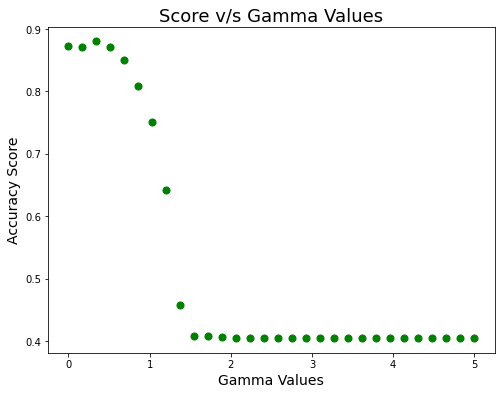

In [39]:
# Plotting Gamma on the x-axis and accuracy on the y-axis. 

fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(gamma_vals, score_values, color='green', marker='o', s=50)
ax.set_title("Score v/s Gamma Values", fontsize=18)
ax.set_xlabel("Gamma Values", fontsize=14)
ax.set_ylabel("Accuracy Score", fontsize=14)
plt.show()

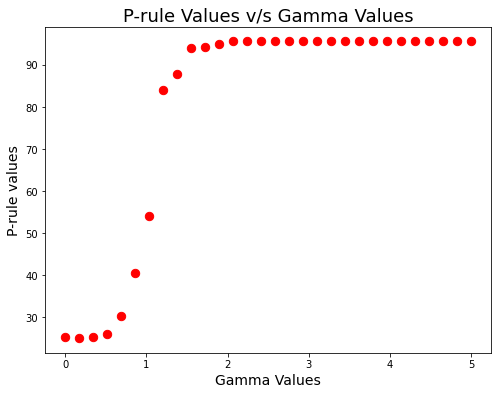

In [38]:
# Plotting gamma on the x-axis and the p-rule on the y-axis. 
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(gamma_vals, p_rule_values, color='red', marker='o', s=70)
ax.set_title("P-rule Values v/s Gamma Values", fontsize=18)
ax.set_xlabel("Gamma Values", fontsize=14)
ax.set_ylabel("P-rule values", fontsize=14)
plt.show()

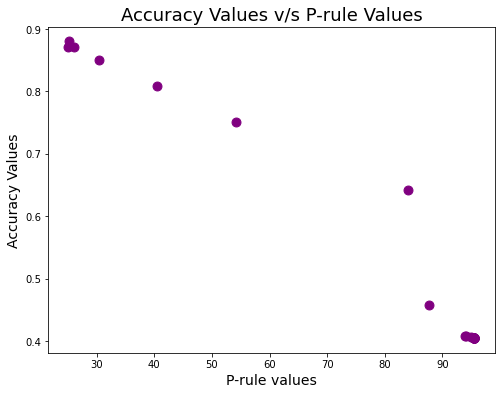

In [37]:
# Plotting p-rule on the x-axis and accuracy on the y-axis. 
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(p_rule_values, score_values, color='purple', marker='o', s=80)
ax.set_title("Accuracy Values v/s P-rule Values", fontsize=18)
ax.set_xlabel("P-rule values", fontsize=14)
ax.set_ylabel("Accuracy Values", fontsize=14)
plt.show()

## Discussion

The following questions have no right answer. Instead, they are meant to make you think about the nuances of navigating correcting for bias in practice. 

**QUESTION A**: What is the "right" value for $\gamma$? Why? Can you think of an empirical way to justify your choice for the "right" gamma value? 

*Answer:* 
The right gamma number, in my opinion, is one that produces a p-rule score that is as near to 100 percent as possible. The reason for choosing such a gamma number is that a 100 percent p-rule score implies that the hiring ratio for protected and unprotected groups is roughly equal. In other words, it indicates that there is no discrimination or special treatment based on the sensitive characteristic. Another reason I choose such a gamma value is that there is nothing that distinguishes the two sensitive feature group members' working abilities. If the two group members are equally skilled and qualified, selecting a value with a p-rule score less than 100 percent will leave a component of discrimination.

**QUESTION B**: What kinds of discussions or decision making processes could help us agree on $\gamma$? 


*Answer:* 
Biases in the case of Machine learning are more about the failures of the models to forsee their negative impacts, which in ours case are disparate impacts between female and male hires. I believe that we all agree with the fact that there should be no disparate impacts or other differences in the hiring process based on any sensitive feature (gender, age, ethnicity etc), so the gama chosen, should be the one that yields the most equity --> 100% p-rule value, and in our case that is close to gamma ~ 5.

We do this to:
- Achieve hiring decisions made on the basis of absolute equity and impartiality. 

- Decision-making accuracy should not be used as a decisive factor because the accuracy score reinforces pre-existing prejudices. Alternatives to traditional accuracy criteria must be devised in order to achieve equal hiring procedures. One of these is the P-rule, thus our talks should focus on the values we receive for these new measurements. 

- When utilizing models to make hiring decisions, we always need to include the sensitive features in the dataset and accommodate them with gamma value considerations

**QUESTION C**: In the case of hiring, whom should these discussions involve? How about other cases? Remember that different stakeholders have different levels of understanding about machine learning, and different levels of understanding about social issues such as gender and racial bias.

*Answer:* 
Hiring, Employment and many things related to job prospects are social issues, which requires to be treated and engage all the stakeholders in the field (multistakeholder ecosystem). The company's senior management, the hiring manager, the person designing the machine learning model, the company's lawyer, a women's rights advocate, and presumably someone who is an expert in constitutional law should all be present during these discussions. The model will facilitate hiring decision-making, which will have far-reaching repercussions for candidates as well as society, therefore bringing all of these stakeholders together is critical. 

In other circumstances, I believe that the sensitive feature groups should be fairly represented. It would be preferable if we could get lawyers and rights campaigners from both sides. Aside from that, having the model creating team and the ultimate decision-making team participating throughout the process is critical.

**QUESTION D**: Is there some point at which we should stop trying to correct for bias in our data? If so, how do we determine that point?

*Answer:* 
It's really an uphill battle if you ask me, but the focus should always be on equity! 
Even within the gender space, once we've figured out a means to give males and females equal access to opportunities and decision-making, we should aim to make it even more inclusive for other gender groupings. 

I believe the goal should be to maintain a higher level of inclusivity and get closer to a 100 percent p-rule score for the sensitive attribute under debate.

## Bonus Question: Alternative Ways of Defining Fairness  

In this assignment, we have used disparate impact -- as quantified by the p% rule -- to measure bias in our dataset and predictions. However, disparate impact is not the only way to quantify fairness. For this question, we'll look at another option for defining fairness: *disparate mistreatment*, introduced by [Zafar et al. (2017b)](https://dl.acm.org/doi/10.1145/3038912.3052660).  Disparate mistreatment focuses on the misclassification rates between groups -- that is, it compares the *true positive rate* for the protected class to the *true positive rate* for the unprotected class. In the context of our dataset, disparate mistreatment compares the rate at which qualified females are hired in comaprison to the rate at which qualified men are hired. 

Let $\hat{y}$ be the prediction of the classifier for an observation. Then disparate mistreatment is defined as: 

$$ m = 100 \left( \frac{Pr(\hat{y}=1 | y=1, z=1)}{Pr(\hat{y}=1 | y=1, z=0)} \right) $$

Write a function calculate_disparate_mistreatment that takes in a sensitive_features_arr and *y* (the true hiring labels), along with *distances_from_decision_boundary* as outputed by the *train_test_classifier* method, and returns *m*, the measure of disparate mistreatment. Also have your function print out the true positive rate for each of the classes.

In [24]:
# Code up disparate mistreatment
def calculate_disparate_mistreatment(sensitive_features_arr, y, distances_from_decision_boundary, threshold=0):
    
    df = pd.DataFrame(data = sensitive_features_arr, columns = ['sensitive'])
    df['hiring_result'] = y
    df['distances'] = distances_from_decision_boundary
    
    filters = [
        (df.sensitive == 0) & (df.distances > threshold),
        (df.sensitive == 1) & (df.distances > 0), 
        ]

    values = [1, 1]
    df["hiring_prediction"] = np.select(filters, values, default=-1)
    
    sensitive_arr = np.array(df['sensitive'])
    y_arr = np.array(df['hiring_result'])
    yhat_arr = np.array(df['hiring_prediction'])
    
    # Determining the total number of unprotected and protected 
    number_unprotected = np.count_nonzero(sensitive_arr==1)
    number_protected = np.count_nonzero(sensitive_arr==0)
    
    # Determining TP, FP, TN, FN for the protected and unprotected class
    tp_pro = df.groupby(['sensitive', 'hiring_result', 'hiring_prediction']).size()[0,1,1]
    fp_pro = df.groupby(['sensitive', 'hiring_result', 'hiring_prediction']).size()[0,-1,1]
    tn_pro = df.groupby(['sensitive', 'hiring_result', 'hiring_prediction']).size()[0,-1,-1]
    fn_pro = df.groupby(['sensitive', 'hiring_result', 'hiring_prediction']).size()[0,1,-1]
    
    tp_unpro = df.groupby(['sensitive', 'hiring_result', 'hiring_prediction']).size()[1,1,1]
    fp_unpro = df.groupby(['sensitive', 'hiring_result', 'hiring_prediction']).size()[1,-1,1]
    tn_unpro = df.groupby(['sensitive', 'hiring_result', 'hiring_prediction']).size()[1,-1,-1]
    fn_unpro = df.groupby(['sensitive', 'hiring_result', 'hiring_prediction']).size()[1,1,-1]
    
    
    # TODO: Replace 0 with the true positive rate in the unprotected class
    tpr_unprotected = 100*tp_unpro/(tp_unpro + fn_unpro)
    
    # TODO: Replace 0 with the the true positive rate in the protected class
    tpr_protected = 100*tp_pro/(tp_pro + fn_pro)
    
    # TODO: Replace 0 with your calculation of disparate mistreatment
    disparate_mistreatment = 100*tpr_protected/ tpr_unprotected  
    
    print('True positive rate for unprotected class: %i' % tpr_unprotected + '%')
    print('True positive rate for protected class: %i' % tpr_protected + '%')
    print('Disparate mistreatment: %i' % disparate_mistreatment + '%')
    
    return disparate_mistreatment


In [25]:
# Unconstrained classifier
theta, p_rule, score, distances_from_decision_boundary = classify.train_test_classifier(
    X_train, y_train,  x_sensitive_train, 
    X_test, y_test, x_sensitive_test, 
    ['s1'],  # our list of sensitive features.
    apply_fairness_constraints=0 # We are NOT applying any fairness constraints this time
)  

Accuracy: 0.87
Protected/non-protected in positive class: 86% / 22%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 1.181



In [26]:
# Test disparate mistreatment on the predictions of the unconstrained classifier
sensitive_features_arr = np.array(x_sensitive_test['s1'])
calculate_disparate_mistreatment(sensitive_features_arr, y_test, distances_from_decision_boundary)

True positive rate for unprotected class: 97%
True positive rate for protected class: 63%
Disparate mistreatment: 65%


65.5836916706482

In [27]:
# Constrained classifier
theta1, p_rule1, score1, distances_from_decision_boundary = classify.train_test_classifier(
    X_train, y_train, x_sensitive_train, 
    X_test, y_test, x_sensitive_test, 
    ['s1'],  # our sensitive feature
    apply_accuracy_constraint=1, # applying our fairness constraint.
    gamma=1.5 
) 

Accuracy: 0.41
Protected/non-protected in positive class: 60% / 56%
P-rule achieved: 93%
Covariance between sensitive feature and decision from distance boundary : 0.002



In [28]:
# Test disparate mistreatment on the predictions of the constrained classifier
sensitive_features_arr = np.array(x_sensitive_test['s1'])
calculate_disparate_mistreatment(sensitive_features_arr, y_test, distances_from_decision_boundary)

True positive rate for unprotected class: 58%
True positive rate for protected class: 26%
Disparate mistreatment: 44%


44.94065934065934

**QUESTION A**: Did using a classifier that was constrained to reduce disparate impact improve disparate mistreatment?

*Answer:* Using the constrained classifier resulted in a decrease in disparate mistreatment as well as disparate impact. 

**QUESTION B**: In general, what is the relationship between disparate impact and disparate mistreatment? Why? *Hint*: A useful resource for this question is [Barocas et al. (2019)](https://fairmlbook.org), Chapter 2. Barocas et al. use different terms for the fairness metrics we study here: disparate impact is referred to as *independence* and disparate mistreatment is referred to as *separation*. 

*Answer:* Disparate mistreatment should improve as disparate impact decreases, i.e. the true positive rate (as well as the false positive rate) for the two sensitive groups should converge to the same value.

# Conclusion

Even if we exclude sensitive attributes from our training procedure, models trained on biased data with strong correlations between sensitive and non-sensitive attributes can still replicate or even emphasize that bias in their predictions. 

We can correct for that bias, but doing so will *always* incur tradeoffs in accuracy. In a way, our bias correction is a claim that the data are "misclassified" in the first place. In this lab's example, we think there are too few women labeled as "hired." So we're finding a compromise between correcting that bias and fitting the data we already have.

Based on a paper by Zafar et. al, we demonstrated a bias correction method we can control by setting the hyperparameter $\gamma$. 
But remember: different industries often have different standards for how fair is "fair enough" or how accurate is "accurate enough" for a model to be considered acceptable for use. 

## Appendix


### Generating the toy dataset
To generate the non-sensitive features, we assign each class a bivariate Gaussian distribution and draw the 2 non-sensitive features for each data point from the appropriate distribution. To generate a biased sensitive feature correlated with the non-sensitive features, we rotate the non-sensitive features; the closer the rotation angle is to 0, the more correlated our sensitive feature will be to the non-sensitive features. We use these rotated coordinates to generate a Bernoulli distribution from which to draw the binary sensitive feature. We set the parameters of this distribution such that an individual in the dataset is more likely to be in the unprotected sensitive group (sensitive feature = 1) if the rotated non-sensitive features are also more likely to belong to the positive class (class label = 1).

### Applying fairness constraints

To do so, we first define the _decision boundary covariance_ as a measure of the covariance between the sensitive feature $\mathbf{z}$ and the classifier's decision $d_{\boldsymbol{\theta}}(\mathbf{x})$. For a logistic regression classifier, the classifier's decision is based on the dot product of the parameters $\boldsymbol{\theta}$ that the model learns and the feature values $\mathbf x$.

$$ Cov(\mathbf{z}, d_{\boldsymbol{\theta}}(\mathbf{x})) = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{z}_i-\bar{\mathbf{z}}) \boldsymbol{\theta}^T  \mathbf x_i$$

Now, the whole idea here is that
we *don't* want the sensitive feature to influence our classifier's decision.
Put another way,
we want to demonstrate that the sensitive feature and the classifier's decision boundary don't covary---or, at least that the decision boundary covariance is close to 0. Now, we could adjust the classifier to minimize the decision boundary covariance, but this might lead to a significant loss in accuracy which could make our model unusable in practice. 

Instead, we want to make our decisions as fairly as possible, with some limit on how low the accuracy can be to produce a functional classifier. So we can set up a mathematical way to frame the trade-off between accuracy and fairness: 
we can minimize the decision boundary covariance (maximize fairness) given some upper bound on the model's loss (an accuracy constraint).

If $Loss(\boldsymbol{\theta}^*)$ represents the loss of our baseline classifier without any bias correction, we can set the parameter $\gamma$ to specify how much additional loss we are willing to add to the baseline loss. 
So our bias correction method can be written:

$$ \text{find}\ \boldsymbol{\theta}\ \text{that minimizes} \ \ \ \big \lvert Cov(\mathbf{z}, d_{\boldsymbol{\theta}}(\mathbf{x})) \big\rvert $$

$$ \text{subject to} \ \ \ Loss(\boldsymbol{\theta}) \le (1+\gamma)Loss(\boldsymbol{\theta}^*)$$

We refer to this constraint as the hyperparameter gamma ($\gamma$).